In [1]:
import sys
sys.path.insert(1, 'C:/Users/fabio/Desktop/ML4Fin Unibo')

import numpy  as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import keras
from tensorflow.keras.callbacks import EarlyStopping

from pickle import dump
import re

import matplotlib.pyplot as plt

from utils import plot_nnpredict_45

In [2]:
TAG = '1986436'    # same as the seed you set for generation

inputFile = 'full_%s.csv' %TAG
resFile = re.sub("\..*$","_trained.png", inputFile)
scalerFile = "scaler_%s.pkl" %TAG
mdlDir = "model_%s.krs" %TAG

<h3> import db for training ...

In [3]:
print("@ %-11s: reading training data from '%s'" %("Info", inputFile))
db_full = pd.read_csv(inputFile, sep=',')

@ Info       : reading training data from 'full_1986436.csv'


>    and check it reads as expected

In [4]:
print(db_full.head(5))

          T      Sgma    Strike     Price
0  1.562515  0.647954  0.805646  0.377554
1  0.902237  0.724046  0.704645  0.418974
2  1.239975  0.672987  0.698822  0.448409
3  1.816208  0.531236  1.057050  0.228295
4  1.797256  0.617445  1.052252  0.356805


<h3> preprocessing input data

>    isolate x and y variables

In [5]:
prices = db_full["Price"]
params = db_full.drop(columns="Price")

>    define a scaler to normalize x variables

In [6]:
scaler = StandardScaler().fit(params)

>    divide into train and test

In [7]:
x_train, x_test, y_train, y_test = train_test_split(params, prices, test_size=0.33, random_state=42)

>    transform x variables according to the scaler

In [8]:
x_train_transform = scaler.transform(x_train)
x_test_transform = scaler.transform(x_test)

<h3> build the neural network

In [9]:
N_hiddenLayers = 2
N_nodes = 64
i = keras.layers.Input(shape=(3, ))
x = keras.layers.Dense(N_nodes, activation='relu')(i)
c = 0
while c < N_hiddenLayers:
    x = keras.layers.Dense(N_nodes, activation='relu')(x)
    c += 1
x = keras.layers.Dense(1, activation='linear')(x)

model = keras.models.Model(inputs=i, outputs=x)

>    and print it to screen

In [10]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3)]               0         
                                                                 
 dense (Dense)               (None, 64)                256       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8,641
Trainable params: 8,641
Non-trainable params: 0
_________________________________________________________________


<h3> compile

In [11]:
model.compile(loss='mse', optimizer='adam')

<h3> and train

In [12]:
LEN = len(x_train_transform)
patience = 50
N_epochs = 500

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=patience)

model.fit(x_train_transform, y_train, epochs=N_epochs, verbose=True, batch_size=LEN, validation_split=.25, 
          callbacks=[early_stopping])

Epoch 1/500
1/1 [==============================] - 0s 467ms/step - loss: 0.1303 - val_loss: 0.0980
Epoch 2/500
1/1 [==============================] - 0s 32ms/step - loss: 0.0943 - val_loss: 0.0696
Epoch 3/500
1/1 [==============================] - 0s 29ms/step - loss: 0.0667 - val_loss: 0.0491
Epoch 4/500
1/1 [==============================] - 0s 28ms/step - loss: 0.0469 - val_loss: 0.0353
Epoch 5/500
1/1 [==============================] - 0s 27ms/step - loss: 0.0337 - val_loss: 0.0267
Epoch 6/500
1/1 [==============================] - 0s 29ms/step - loss: 0.0258 - val_loss: 0.0219
Epoch 7/500
1/1 [==============================] - 0s 30ms/step - loss: 0.0215 - val_loss: 0.0195
Epoch 8/500
1/1 [==============================] - 0s 28ms/step - loss: 0.0195 - val_loss: 0.0184
Epoch 9/500
1/1 [==============================] - 0s 28ms/step - loss: 0.0186 - val_loss: 0.0177
Epoch 10/500
1/1 [==============================] - 0s 29ms/step - loss: 0.0180 - val_loss: 0.0167
Epoch 11/500
1/1 [

<h3> display in sample and out of sample performance of the model

>    also save the resuts in a csv file in passing

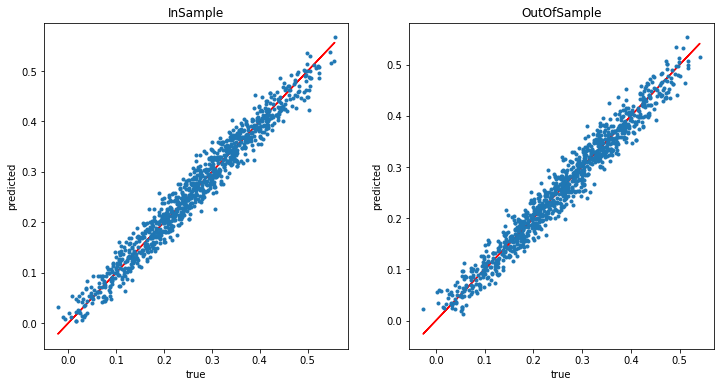

In [13]:
n = 2
fig, ax = plt.subplots(1,n, figsize=(12,6))

title = ["InSample", "OutOfSample"]

x = [x_train_transform, x_test_transform]
y = [y_train, y_test]
y_hat = []
for i in range(n):
    y_hat.append(np.ravel(model.predict(x[i])))

saveData = True
    
N = 1000
for i in range(n):
    plot_nnpredict_45(y[i][:N], y_hat[i][:N], title[i], ax=ax[i])
    if saveData:
        diff = np.fabs(y[i] - y_hat[i])
        RES = pd.DataFrame({"predicted": y_hat[i], "target": y[i], "err:": diff})
        RES.to_csv("res_"+title[i]+".csv", sep=',', float_format="%.6f", index=True)   
        
plt.savefig(resFile, format="png")

<h3> save the model and the scaler applied to the x variables

In [14]:
dump(scaler, open(scalerFile, 'wb'))
print("@ %-11s: scaler saved to '%s'" %("Info", scalerFile))

model.save(mdlDir)
print("@ %-11s: model saved to '%s'" %("Info", mdlDir))

@ Info       : scaler saved to 'scaler_1986436.pkl'
INFO:tensorflow:Assets written to: model_1986436.krs\assets
@ Info       : model saved to 'model_1986436.krs'
